In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import glob
import pandas as pd
import mplniw.utils as ut
from datetime import timedelta, datetime
import mplniw.plot as pl

In [2]:
root_dir = '/Users/zcasparcohen/Documents/NISKINE/data/'
os.listdir(root_dir)

['v1',
 'linear_merge_linear_gaps.nc',
 '.DS_Store',
 'FQ_InterpolatedFinal.mat',
 'niskine_mooring_locations.nc',
 'linear_merge_cubic_gaps.nc',
 't_10m_2min.nc',
 'woce_argo_global_hydrographic_climatology',
 'gridded']

In [3]:
def interpolation(arraylist, z_new, t_new, fill_gaps=True, **kwargs):
    # Sorting down and up adcps:
    down = [v for v in arraylist if v.orientation=='down']
    up = [v for v in arraylist if v.orientation=='up']
    #Subsampling
    down_sub = [v.sel(time=slice(t_new[0],t_new[-1])) for v in down]
    up_sub = [v.sel(time=slice(t_new[0],t_new[-1])) for v in up]
    # Interpolation on a regular temporal grid
    down_interp = [v.interp(time=t_new) for v in down_sub if v.time.size>=10000]
    up_interp = [v.interp(time=t_new) for v in up_sub if v.time.size>=10000]
    down_interpz = [v.interp(z=z_new) for v in down_interp]
    up_interpz = [v.interp(z=z_new) for v in up_interp]
    if len(down_interpz)==2:
        _=down_interpz[1].combine_first(down_interpz[0])
    elif len(down_interpz)==1:
        _=down_interpz[0]
    else:
        _=down_interpz[1].combine_first(down_interpz[0]).combine_first(down_interpz[2])
    if len(up_interpz)==1:
        ds = up_interpz[0].combine_first(_)
    elif len(up_interpz)==2:
        ds = up_interpz[0].combine_first(up_interpz[1]).combine_first(_)
    else:
        ds = _
        
    if fill_gaps:
        return ds,ds.interpolate_na(dim='z',**kwargs)
    else:
        return ds
   # return down_interpz,up_interpz


In [4]:
mooring = 'M1'
listfile = sorted(filter(os.path.isfile,glob.glob(root_dir+'v1/'+mooring+'*')))
arraylist = [xr.open_dataset(file) for file in listfile]

t_new = pd.date_range(start='2019-05-17T16', end='2020-10-06T00', freq=timedelta(minutes=10))
z_new = np.arange(0,2000,16)

In [5]:
ds,ds_fill = interpolation(arraylist,z_new,t_new,**{'method':'linear'})
ds_cubic,ds_fill_cubic = interpolation(arraylist,z_new,t_new,**{'method':'cubic'})

In [6]:
ds_gridded = xr.open_dataset(root_dir+'gridded/'+mooring+'_gridded_simple_merge_gaps_filled.nc')
ds_gaps = xr.open_dataset(root_dir+'gridded/'+mooring+'_gridded_simple_merge.nc')

(<Figure size 1200x500 with 4 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

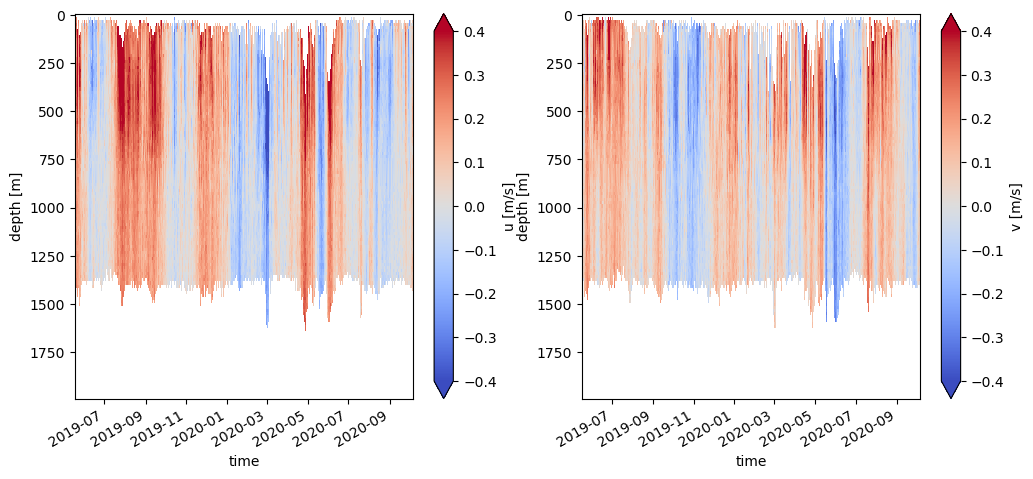

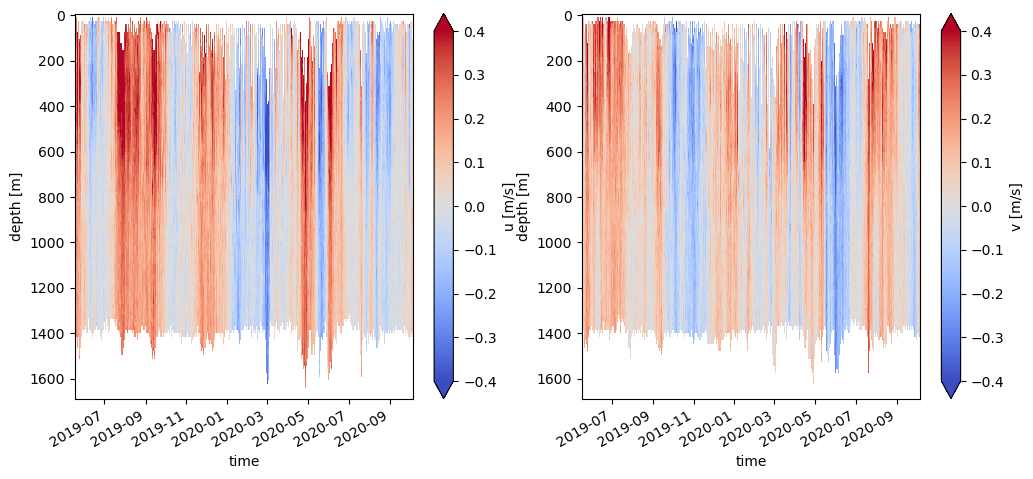

In [11]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.plot_uv(ds_fill,'u',fig,ax)
ax = fig.add_subplot(122)
pl.plot_uv(ds_fill,'v',fig,ax)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.plot_uv(ds_gridded,'u',fig,ax)
ax = fig.add_subplot(122)
pl.plot_uv(ds_gridded,'v',fig,ax)

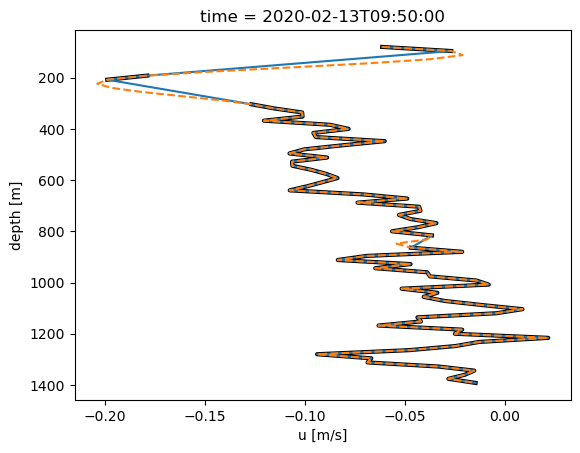

In [7]:
t = '2020-02-13T09:50:00'
ds.u.sel(time=t,method='nearest').plot(c='k',lw=3,y='z',yincrease=False)
ds_fill.u.sel(time=t,method='nearest').plot(y='z',yincrease=False)
ds_fill_cubic.u.sel(time=t,method='nearest').plot(y='z',yincrease=False,ls='--')


#plt.figure()
#ds_gaps.u.sel(time=t,method='nearest').plot(lw=3,c='k',y='z',yincrease=False)
#ds_gridded.u.sel(time=t,method='nearest').plot(y='z',yincrease=False)


In [13]:
# Save files
ds_fill.to_netcdf('/Users/zcasparcohen/Documents/NISKINE/data/linear_merge_linear_gaps.nc','w')
ds_fill_cubic.to_netcdf('/Users/zcasparcohen/Documents/NISKINE/data/linear_merge_cubics_gaps.nc','w')

### Notes
A cubic (or quadratic) interpolation to fill gaps in the depth range is doing better than a linear one in large gaps.
The impact of a change of interpolation method should be investigated after filtering.